In [162]:
import pandas as pd
import matplotlib.pyplot as pl
from keras.preprocessing.text import one_hot
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)




In [163]:
df_main=pd.read_json('train-v2.0.json')

In [164]:
df_main.head()

,version,data
0,v2.0,"{'title': 'Beyoncé', 'paragraphs': [{'qas': [{..."
1,v2.0,"{'title': 'Frédéric_Chopin', 'paragraphs': [{'..."
2,v2.0,{'title': 'Sino-Tibetan_relations_during_the_M...
3,v2.0,"{'title': 'IPod', 'paragraphs': [{'qas': [{'qu..."
4,v2.0,{'title': 'The_Legend_of_Zelda:_Twilight_Princ...


In [165]:
df_main.shape

(442, 2)

In [166]:
temp=df_main['data'][0]

In [167]:
par=temp['paragraphs']

In [168]:
ques=par[0]['qas']
ques[0]

{'question': 'When did Beyonce start becoming popular?',
 'id': '56be85543aeaaa14008c9063',
 'answers': [{'text': 'in the late 1990s', 'answer_start': 269}],
 'is_impossible': False}

In [169]:
title=[]
questions=[]
answers=[]
answer_start=[]
is_answerable=[]

In [170]:
for sample in df_main['data']:
    pars=sample['paragraphs']
    for par in pars:
        ques=par['qas']
        for i in ques:
            questions.append(i['question'])
            if i['answers']:
                answers.append(i['answers'][0]['text'])
                answer_start.append(i['answers'][0]['answer_start'])
            else:
                answers.append('Null')
                answer_start.append('Null')
            is_answerable.append(i['is_impossible'])

In [171]:
len(questions),len(answers),len(answer_start),len(is_answerable)

(130319, 130319, 130319, 130319)

In [172]:
df=pd.DataFrame({'Question':questions,
                 'Answers':answers,
                 'Answer_start':answer_start,
                 'Is_answerable':is_answerable
                })

In [173]:
df.head(10)

,Question,Answers,Answer_start,Is_answerable
0,When did Beyonce start becoming popular?,in the late 1990s,269,False
1,What areas did Beyonce compete in when she was...,singing and dancing,207,False
2,When did Beyonce leave Destiny's Child and bec...,2003,526,False
3,In what city and state did Beyonce grow up?,"Houston, Texas",166,False
4,In which decade did Beyonce become famous?,late 1990s,276,False
5,In what R&B group was she the lead singer?,Destiny's Child,320,False
6,What album made her a worldwide known artist?,Dangerously in Love,505,False
7,Who managed the Destiny's Child group?,Mathew Knowles,360,False
8,When did Beyoncé rise to fame?,late 1990s,276,False
9,What role did Beyoncé have in Destiny's Child?,lead singer,290,False


In [174]:
dev_data=pd.read_json('dev-v2.0.json')

In [175]:
questions=[]
answers=[]
answer_start=[]
is_answerable=[]
for sample in dev_data['data']:
    pars=sample['paragraphs']
    for par in pars:
        ques=par['qas']
        for i in ques:
            questions.append(i['question'])
            if i['answers']:
                answers.append(i['answers'][0]['text'])
                answer_start.append(i['answers'][0]['answer_start'])
            else:
                answers.append('Null')
                answer_start.append('Null')
            is_answerable.append(i['is_impossible'])
dev_df=pd.DataFrame({'Question':questions,
                 'Answers':answers,
                 'Answer_start':answer_start,
                 'Is_answerable':is_answerable
                })

In [176]:
dev_df

,Question,Answers,Answer_start,Is_answerable
0,In what country is Normandy located?,France,159,False
1,When were the Normans in Normandy?,10th and 11th centuries,94,False
2,From which countries did the Norse originate?,"Denmark, Iceland and Norway",256,False
3,Who was the Norse leader?,Rollo,308,False
4,What century did the Normans first gain their ...,10th century,671,False
...,...,...,...,...
11868,What is the seldom used force unit equal to on...,sthène,665,False
11869,What does not have a metric counterpart?,Null,Null,True
11870,What is the force exerted by standard gravity ...,Null,Null,True
11871,What force leads to a commonly used unit of mass?,Null,Null,True


<IPython.core.display.Javascript object>

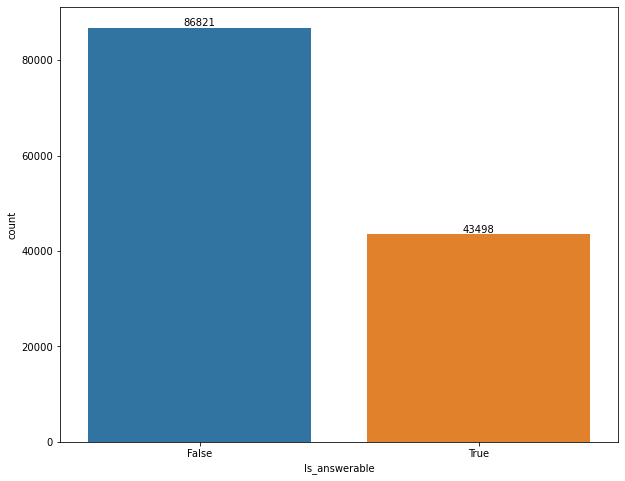

In [177]:
pl.figure(figsize=(10,8))

ax=sns.countplot(df['Is_answerable'])
rects=ax.patches

for rect in rects:
    height=rect.get_height()
    ax.text(x=rect.get_x()+rect.get_width()/2,y=height+5,s=height,ha='center',va='bottom')
pl.show()

<IPython.core.display.Javascript object>

-0.4 0.8
0.6 0.8


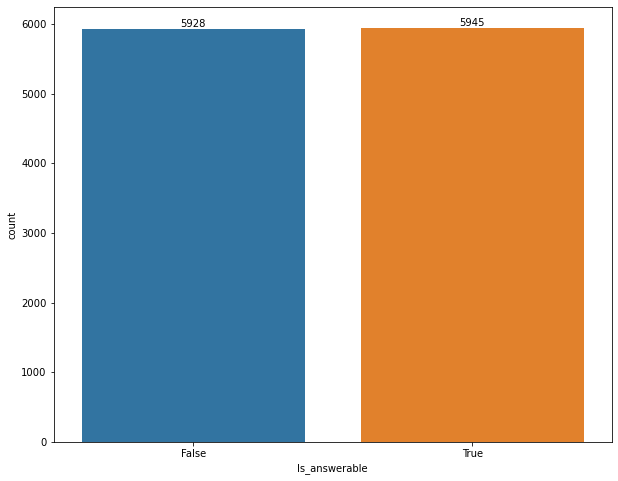

In [178]:
pl.figure(figsize=(10,8))

ax=sns.countplot(dev_df['Is_answerable'])
rects=ax.patches
for rect in rects:
    height=rect.get_height()
    print(rect.get_x(),rect.get_width())
    ax.text(x=rect.get_x()+rect.get_width()/2,y=height+1,s=height,ha='center',va='bottom')
pl.show()

In [179]:
len(df),df['Answer_start'].nunique()

(130319, 1604)

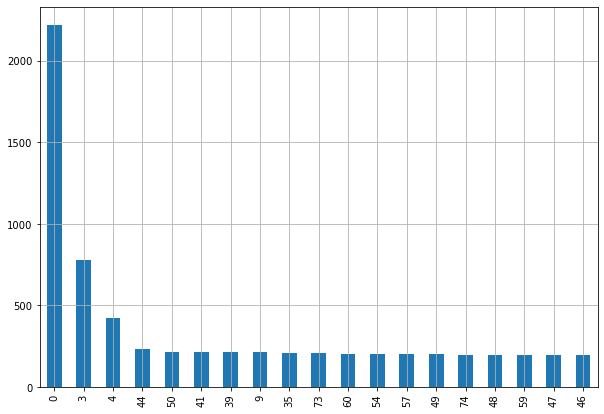

In [180]:
df['Answer_start'].value_counts()[1:20].plot(kind='bar',figsize=(10,7))
pl.grid()
pl.show()

In [181]:
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

In [182]:
df['len_que']=df['Question'].apply(lambda x: len(x))
df['len_ans']=df['Answers'].apply(lambda x: len(x))

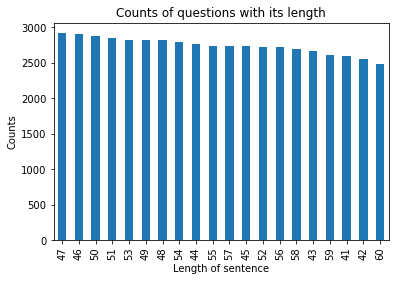

In [183]:
df['len_que'].value_counts()[:20].plot.bar()
pl.title('Counts of questions with its length')
pl.xlabel('Length of sentence')
pl.ylabel('Counts')
pl.show()

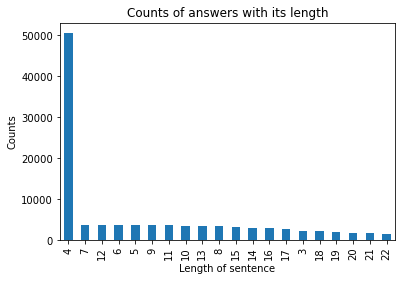

In [184]:
df['len_ans'].value_counts()[:20].plot.bar()
pl.title('Counts of answers with its length')
pl.xlabel('Length of sentence')
pl.ylabel('Counts')
pl.show()

In [185]:
df.describe()

,len_que,len_ans
count,130319.000000,130319.000000
mean,58.507739,14.758884
std,73.757111,19.193666
min,1.000000,1.000000
25%,44.000000,4.000000
50%,55.000000,7.000000
75%,69.000000,17.000000
max,25651.000000,239.000000


In [186]:
df.drop(107709,axis=0,inplace=True)

In [187]:
df.reset_index(drop=True,inplace=True)

In [188]:
df.head()

,Question,Answers,Answer_start,Is_answerable,len_que,len_ans
0,When did Beyonce start becoming popular?,in the late 1990s,269,False,40,17
1,What areas did Beyonce compete in when she was...,singing and dancing,207,False,58,19
2,When did Beyonce leave Destiny's Child and bec...,2003,526,False,64,4
3,In what city and state did Beyonce grow up?,"Houston, Texas",166,False,45,14
4,In which decade did Beyonce become famous?,late 1990s,276,False,42,10


In [189]:
len(df)

130318

In [190]:
df=df.sort_values('len_que',ascending=False)[5000:].copy()

In [234]:
df_s=df[df['Answers']!='Null'].copy()

In [237]:
df_s=df_s.sample(10000).copy()

In [239]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

In [240]:
for line,t in zip(df_s['Question'],df_s['Answers']):
    input_texts.append(line)
    t = '\t' + t + '\n'
    target_texts.append(t)
    for char in line:
        if char not in input_characters:
            input_characters.add(char)
    for char in t:
        if char not in target_characters:
            target_characters.add(char)

In [245]:
input_texts[10],target_texts[10]

('When did Congress pass the Espionage Act?', '\t1917\n')

In [194]:
print(input_characters)

{'7', ']', 'ł', ' ', 'a', ';', 'm', 'ø', '0', 'Z', '–', 'ī', 'E', 'á', '"', 'h', 'ó', '1', 'o', '.', '8', 'ê', 'S', '3', 'ę', 'ā', 'J', 'ü', 'Y', '+', 'C', '£', 'õ', 't', 'j', '’', ')', 'B', '6', 'r', 'c', 'I', '=', '/', '?', 'G', 'L', 'T', '%', 'ś', 'V', 'w', '&', 'É', '2', 'g', '(', 'Q', '5', 'P', '[', 'n', 'í', 'ã', '❤', 'O', '²', 'y', 'N', 'z', 'é', 'A', 'f', 'H', 'X', 'ɪ', '<', 'U', 'D', 'Ö', 'M', 'ò', 'K', 'k', 'e', ':', 'd', 'p', 'b', '$', 'v', 'W', 'i', 's', 'q', 'F', '4', 'x', "'", '9', '-', ',', 'R', 'u', 'l'}


In [195]:
print(target_characters)

{'7', 'ş', ']', 'ł', ' ', '#', 'a', ';', 'ō', 'ʻ', 'm', '0', 'Z', '–', 'ī', 'E', 'ƿ', '>', 'á', 'æ', '"', 'ə', '\n', 'h', 'ó', '1', 'o', '.', '8', 'S', 'ô', '3', 'ā', 'J', 'ü', 'Y', '+', 'C', '£', 't', 'î', '“', 'j', ')', 'B', '6', 'r', 'c', '¢', 'I', 'ö', 'Ü', 'Š', 'G', 'ă', '/', '%', 'T', 'L', '?', 'ç', 'ś', 'ē', 'ž', 'V', 'w', '!', '&', 'É', '2', 'g', '(', 'Q', '5', 'P', '[', 'Ś', 'β', 'n', '€', 'í', 'ã', '”', 'O', '²', 'y', 'N', 'z', 'é', 'A', 'f', 'H', 'X', 'à', 'ū', 'U', 'ë', 'D', 'ñ', 'M', '×', 'K', 'ć', 'k', 'e', '\t', ':', 'd', '₤', 'p', 'b', '$', 'â', 'v', '°', 'W', 'i', 's', '−', 'q', 'è', 'F', '4', 'ż', 'å', '\u202f', 'x', 'š', 'ä', "'", '9', '-', 'ḷ', 'Ž', ',', 'R', 'ú', 'u', 'l'}


In [196]:
input_characters=sorted(list(input_characters))
target_characters=sorted(list(target_characters))
num_encoder_tokens=len(input_characters)
num_decoder_tokens=len(target_characters)
max_encoder_len=max([len(txt) for txt in input_texts])
max_decoder_len=max([len(txt) for txt in target_texts])


print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_len)
print('Max sequence length for outputs:', max_decoder_len)

Number of samples: 10000
Number of unique input tokens: 105
Number of unique output tokens: 139
Max sequence length for inputs: 100
Max sequence length for outputs: 172


In [197]:
input_token_index=dict([(char,i) for i,char in enumerate(input_characters)])
target_token_index=dict([(char,i) for i,char in enumerate(target_characters)])

In [198]:
print(input_token_index)

{' ': 0, '"': 1, '$': 2, '%': 3, '&': 4, "'": 5, '(': 6, ')': 7, '+': 8, ',': 9, '-': 10, '.': 11, '/': 12, '0': 13, '1': 14, '2': 15, '3': 16, '4': 17, '5': 18, '6': 19, '7': 20, '8': 21, '9': 22, ':': 23, ';': 24, '<': 25, '=': 26, '?': 27, 'A': 28, 'B': 29, 'C': 30, 'D': 31, 'E': 32, 'F': 33, 'G': 34, 'H': 35, 'I': 36, 'J': 37, 'K': 38, 'L': 39, 'M': 40, 'N': 41, 'O': 42, 'P': 43, 'Q': 44, 'R': 45, 'S': 46, 'T': 47, 'U': 48, 'V': 49, 'W': 50, 'X': 51, 'Y': 52, 'Z': 53, '[': 54, ']': 55, 'a': 56, 'b': 57, 'c': 58, 'd': 59, 'e': 60, 'f': 61, 'g': 62, 'h': 63, 'i': 64, 'j': 65, 'k': 66, 'l': 67, 'm': 68, 'n': 69, 'o': 70, 'p': 71, 'q': 72, 'r': 73, 's': 74, 't': 75, 'u': 76, 'v': 77, 'w': 78, 'x': 79, 'y': 80, 'z': 81, '£': 82, '²': 83, 'É': 84, 'Ö': 85, 'á': 86, 'ã': 87, 'é': 88, 'ê': 89, 'í': 90, 'ò': 91, 'ó': 92, 'õ': 93, 'ø': 94, 'ü': 95, 'ā': 96, 'ę': 97, 'ī': 98, 'ł': 99, 'ś': 100, 'ɪ': 101, '–': 102, '’': 103, '❤': 104}


In [199]:
print(target_token_index)

{'\t': 0, '\n': 1, ' ': 2, '!': 3, '"': 4, '#': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, '+': 12, ',': 13, '-': 14, '.': 15, '/': 16, '0': 17, '1': 18, '2': 19, '3': 20, '4': 21, '5': 22, '6': 23, '7': 24, '8': 25, '9': 26, ':': 27, ';': 28, '>': 29, '?': 30, 'A': 31, 'B': 32, 'C': 33, 'D': 34, 'E': 35, 'F': 36, 'G': 37, 'H': 38, 'I': 39, 'J': 40, 'K': 41, 'L': 42, 'M': 43, 'N': 44, 'O': 45, 'P': 46, 'Q': 47, 'R': 48, 'S': 49, 'T': 50, 'U': 51, 'V': 52, 'W': 53, 'X': 54, 'Y': 55, 'Z': 56, '[': 57, ']': 58, 'a': 59, 'b': 60, 'c': 61, 'd': 62, 'e': 63, 'f': 64, 'g': 65, 'h': 66, 'i': 67, 'j': 68, 'k': 69, 'l': 70, 'm': 71, 'n': 72, 'o': 73, 'p': 74, 'q': 75, 'r': 76, 's': 77, 't': 78, 'u': 79, 'v': 80, 'w': 81, 'x': 82, 'y': 83, 'z': 84, '¢': 85, '£': 86, '°': 87, '²': 88, 'É': 89, '×': 90, 'Ü': 91, 'à': 92, 'á': 93, 'â': 94, 'ã': 95, 'ä': 96, 'å': 97, 'æ': 98, 'ç': 99, 'è': 100, 'é': 101, 'ë': 102, 'í': 103, 'î': 104, 'ñ': 105, 'ó': 106, 'ô': 107, 'ö': 108, 'ú': 109, 'ü': 11

In [200]:
import numpy as np
encoder_input_data=np.zeros(
    (len(input_texts),max_encoder_len,num_encoder_tokens),
    dtype='float32'
)
decoder_input_data=np.zeros(
    (len(target_texts),max_decoder_len,num_decoder_tokens),
    dtype='float32'
)
decoder_target_data = np.zeros(
  (len(input_texts), max_decoder_len, num_decoder_tokens),
  dtype='float32')

In [201]:
encoder_input_data.shape,decoder_input_data.shape

((10000, 100, 105), (10000, 172, 139))

In [202]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
    # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
          # decoder_target_data will be ahead by one timestep
          # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [203]:
len(encoder_input_data[0][0]),len(encoder_input_data[1][8])

(105, 105)

In [204]:
import keras, tensorflow
from keras.models import Model
from keras.layers import Input, LSTM, Dense

In [205]:
batch_size = 64  # batch size for training
epochs = 50  # number of epochs to train for
latent_dim = 256  # latent dimensionality of the encoding space

In [206]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]


decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [207]:
model = Model(inputs=[encoder_inputs, decoder_inputs], 
              outputs=decoder_outputs)

In [208]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, None, 105)    0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           (None, None, 139)    0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, 256), (None, 370688      input_29[0][0]                   
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, None, 256),  405504      input_30[0][0]                   
                                                                 lstm_5[0][1]              

In [209]:
history=model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 28s 4ms/step - loss: 0.2837 - val_loss: 0.2825
Epoch 2/50
8000/8000 [==============================] - 26s 3ms/step - loss: 0.2521 - val_loss: 0.2465
Epoch 3/50
8000/8000 [==============================] - 26s 3ms/step - loss: 0.2289 - val_loss: 0.2340
Epoch 4/50
8000/8000 [==============================] - 27s 3ms/step - loss: 0.2178 - val_loss: 0.2230
Epoch 5/50
8000/8000 [==============================] - 27s 3ms/step - loss: 0.2116 - val_loss: 0.2175
Epoch 6/50
8000/8000 [==============================] - 27s 3ms/step - loss: 0.2069 - val_loss: 0.2130
Epoch 7/50
8000/8000 [==============================] - 28s 3ms/step - loss: 0.2027 - val_loss: 0.2123
Epoch 8/50
8000/8000 [==============================] - 29s 4ms/step - loss: 0.1989 - val_loss: 0.2060
Epoch 9/50
8000/8000 [==============================] - 28s 4ms/step - loss: 0.1953 - val_loss: 0.2031
Epoch 10/50
8000/8000 [==

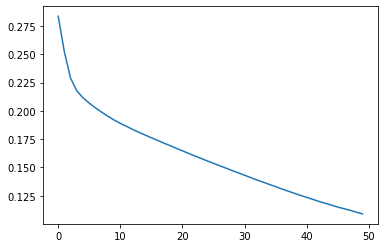

In [210]:
pl.plot(history.history['loss'])

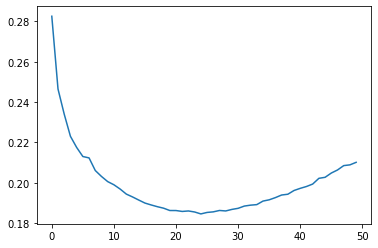

In [211]:
pl.plot(history.history['val_loss'])

In [219]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
  decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
  [decoder_inputs] + decoder_states_inputs,
  [decoder_outputs] + decoder_states)

In [220]:
# reverse-lookup token index to turn sequences back to characters
reverse_input_char_index = dict(
  (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
  (i, char) for char, i in target_token_index.items())

In [221]:
def decode_sequence(input_seq):
  # encode the input sequence to get the internal state vectors.
    states_value = encoder_model.predict(input_seq)
  
  # generate empty target sequence of length 1 with only the start character
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    # output sequence loop
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
          [target_seq] + states_value)

    # sample a token and add the corresponding character to the 
    # decoded sequence
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # check for the exit condition: either hitting max length
        # or predicting the 'stop' character
        if (sampled_char == '\n' or 
            len(decoded_sentence) > max_decoder_len):
                stop_condition = True

        # update the target sequence (length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(10):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: What period of music did the iPod help bring to a close?
Decoded sentence: Null

-
Input sentence: What do choices do camera designs not offer?
Decoded sentence: Null

-
Input sentence: What did motor cars have to follow in the Middle Ages?
Decoded sentence: Null

-
Input sentence: How many citizens of Thuringia are over the age of 65?
Decoded sentence: Null

-
Input sentence: Which early traveler provided an early description of the Rus?
Decoded sentence: Null

-
Input sentence: What ancient world insect is considered symbolic?
Decoded sentence: Null

-
Input sentence: How many planes did Nagumo have for the Midway invasion?
Decoded sentence: Null

-
Input sentence:  Where can you not see mandolins a part of in Portgal?
Decoded sentence: Null

-
Input sentence: How long after the annexation of Kresy was the amendment made?
Decoded sentence: Null

-
Input sentence: What was mined in Pali for The Taj Mahal?
Decoded sentence: Null



In [224]:
input_sentence = "How are you?"
test_sentence_tokenized = np.zeros(
  (1, max_encoder_len, num_encoder_tokens), dtype='float32')
for t, char in enumerate(input_sentence):
    test_sentence_tokenized[0, t, input_token_index[char]] = 1.
print(input_sentence)
print(decode_sequence(test_sentence_tokenized))

How are you?
Null

